In [1]:
println("Hello super people!")

Hello super people!


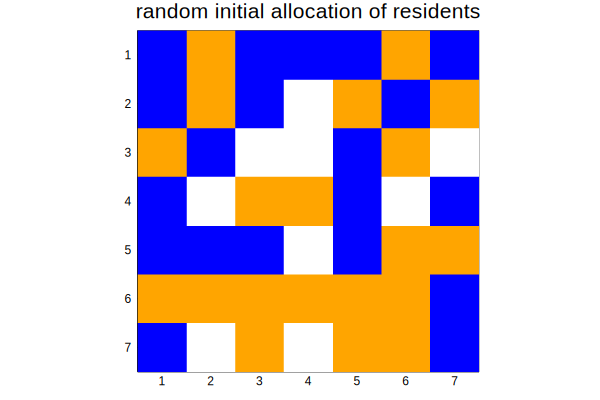

In [116]:
using Random, Plots

#define the grid
#schelling used originally 13x13 grid
GRID_SIZE = 7
CELL_COUNT = GRID_SIZE^2

THRESHOLD_SAME = 5
THRESHOLD_EDGE = 3
THRESHOLD_CORNER = 2

PP = 2.5

yellow_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
blue_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))

empty_grid = zeros(GRID_SIZE,GRID_SIZE)
empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

start_grid = shuffle(empty_grid)

#random initial allocation heatmap viz
#yellow = -1, blue = 1
heatmap(start_grid,title="random initial allocation of residents",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))


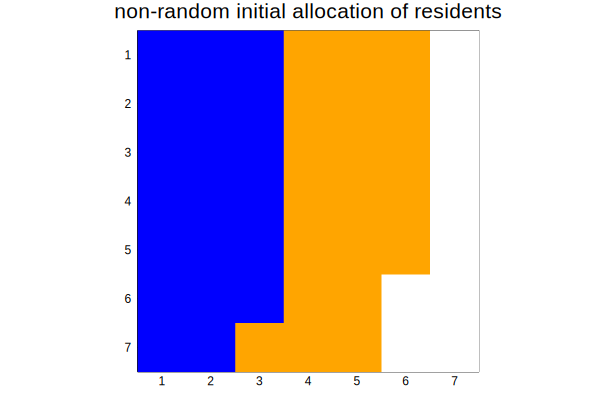

In [117]:
yellow_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
blue_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))

empty_grid = zeros(GRID_SIZE,GRID_SIZE)
empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

set_grid = empty_grid#shuffle(empty_grid)

#random initial allocation heatmap viz
#yellow = -1, blue = 1
heatmap(set_grid,title="non-random initial allocation of residents",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))

In [119]:
#macrostate function mapping (eg, what is the total satisfaction of the residents overall the cells, total sum from zero to max)
#function overall_satisfaction(start_grid)

function grid_satisfaction(grid)
    cell_satisfaction = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            
            t=cell_surround_arrayTMP(grid,row,col)  #R2 = R_grid(start_grid)
            tmpBinary = thresholdFN(t,grid[row,col],row,col)
            append!(cell_satisfaction,tmpBinary)
        end
    end
    return sum(cell_satisfaction)
end

function thresholdFN(cellSurroundArray,cellType,row,col)
    homogeneity = length(findall(cellType .== cellSurroundArray))
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end
function cell_surround_arrayTMP(grid,row,col)
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end

    return cell_surrounding
end

R_MAX = grid_satisfaction(set_grid)
println("set grid satisfaction value MAX=",R_MAX)
R_START = grid_satisfaction(start_grid)
println("set grid satisfaction value START=",R_START)


set grid satisfaction value MAX=37
set grid satisfaction value START=7


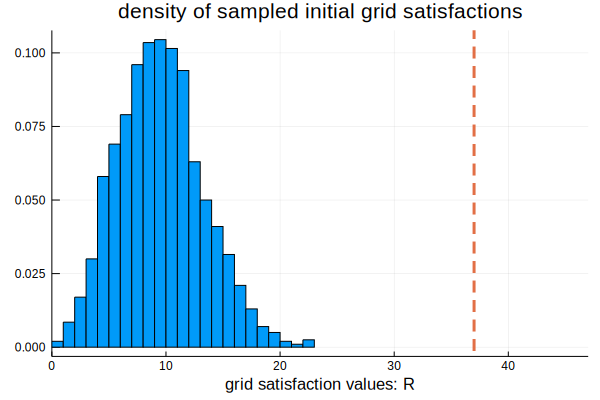

In [120]:
#sample the random intializations and investigate 
function make_random_grid()
    empty_grid = zeros(GRID_SIZE,GRID_SIZE)
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    random_grid = shuffle(empty_grid)
    return random_grid
end
numberOfRandomSamples = 2000
randomSatisfactions = [grid_satisfaction(make_random_grid()) for x in 1:numberOfRandomSamples]
normedRandomSatisfactions = randomSatisfactions ./ sum(randomSatisfactions)
pltHist = histogram(randomSatisfactions,normalize=:probability,xlim=(0,R_MAX+10),title="density of sampled initial grid satisfactions",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)

In [122]:
#llok at not the grid level satisfaction but the single cell level satisfaction
function cell_surround_array(grid,row,col)
    #if((row==1 && col==1))#top left corner
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end
  
    return cell_surrounding
end

function is_cell_satisfied(grid,row,col)
    cellSurroundArray = cell_surround_array(grid,row,col)
    #println(cellSurroundArray)
    cellType = grid[row,col]
    #println(cellType)
    homogeneity = length(findall(cellType .== cellSurroundArray))
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end 

#cell_satisfied = is_cell_satisfied(start_grid,8,7)
#println(cell_satisfied)
 


is_cell_satisfied (generic function with 1 method)

In [124]:
#testing for if a cell would be satisfied if it were placed there
function would_cell_be_satisfied(grid,row,col,cellType)
    cellSurroundArray = cell_surround_array(grid,row,col)    
    #println(cellSurroundArray)
    homogeneity = length(findall(cellType .== cellSurroundArray))    
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end 

#cell_satisfied = would_cell_be_satisfied(start_grid,7,9,start_grid[2,2])
#println(cell_satisfied)
 

would_cell_be_satisfied (generic function with 1 method)

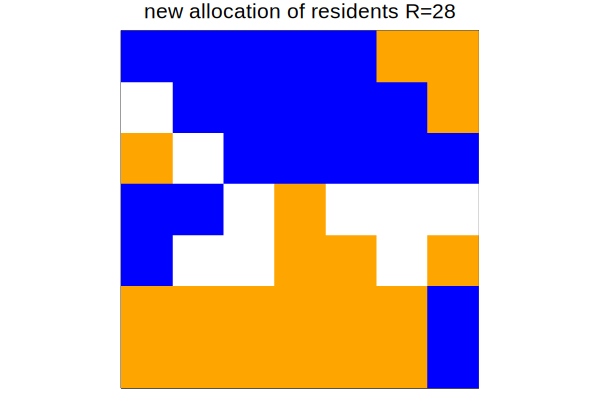

In [129]:
#get non-empty cell set
#Search for an unsatisfied iteratively in all the cells through a shuffled list
#find all empty cells
#shuffle the list of the empty cells
#see if the cell would_cell_be_satisfied in any of the cells in sequence
#no, move on to the next cell
#if yes, change the original cell position to empty and make the new cell the cell type
#loop till all non-empty cells are tested

function move_cells_for_satisfaction(grid)
    
    newGrid = copy(grid)
    nonZeroCells = findall(grid .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)
    satisfiedNonZeroCells = [is_cell_satisfied(newGrid,nzc[1],nzc[2]) for nzc in nonZeroCells2]    
    R_START = grid_satisfaction(grid)

    #remove the satisfied, don't include them in the rotation on each iteration
    satisfiedInds = findall(satisfiedNonZeroCells .== 1)
    deleteat!(nonZeroCells2,satisfiedInds)   
    
    for nzc in nonZeroCells2        
        isCellSatisfied = is_cell_satisfied(newGrid,nzc[1],nzc[2])
        
        if(isCellSatisfied != 1)          
            emptyCells = findall(newGrid .== 0)
            emptyCells2 = shuffle(emptyCells)
            #find an empty cell nzc could move to
            for ec in emptyCells2                
                wouldCellBeSatisfied = would_cell_be_satisfied(newGrid,ec[1],ec[2],newGrid[nzc[1],nzc[2]] )
                if(wouldCellBeSatisfied == 1)  
                    
                    newGrid[ec[1],ec[2]] = newGrid[nzc[1],nzc[2]]
                    newGrid[nzc[1],nzc[2]] = 0  
                    #no longer try to move it
                    break
                end                
            end            
        end       
    end
    
    return newGrid
end

newGrid = move_cells_for_satisfaction(start_grid)

satisfiedOneGrid = grid_satisfaction(newGrid)
#println(satisfiedOneGrid)
heatmap(newGrid,title="new allocation of residents R=$(satisfiedOneGrid)",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))


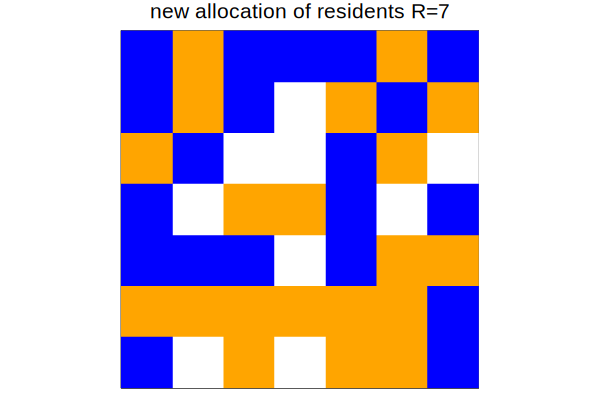

tt=0


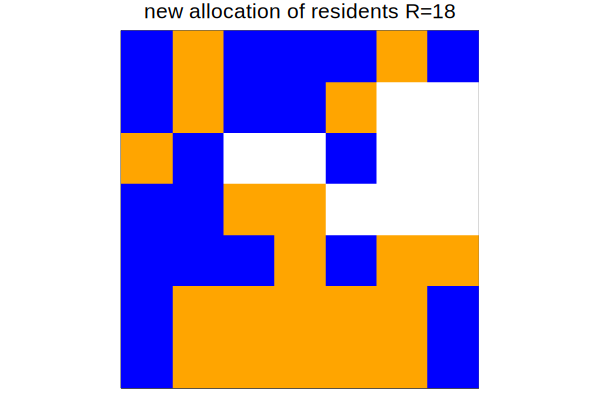

tt=1


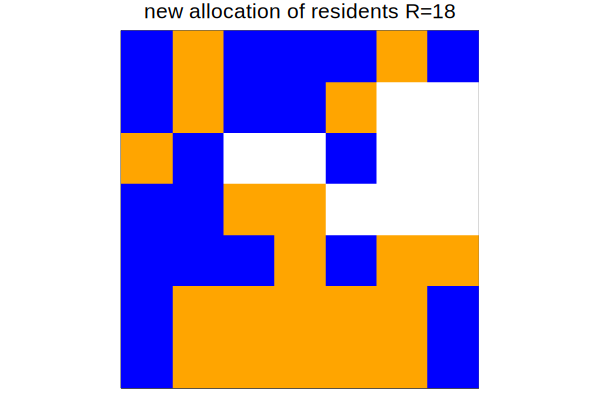

tt=2


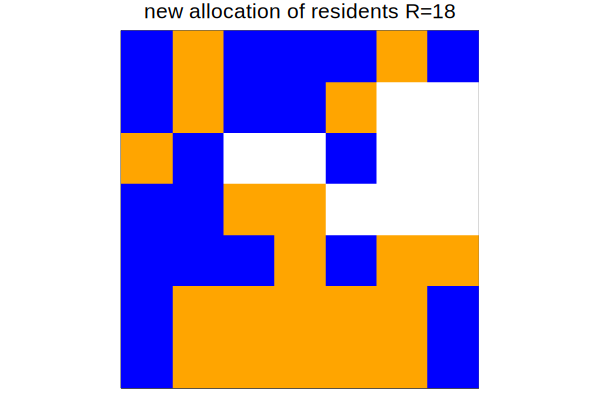

tt=3


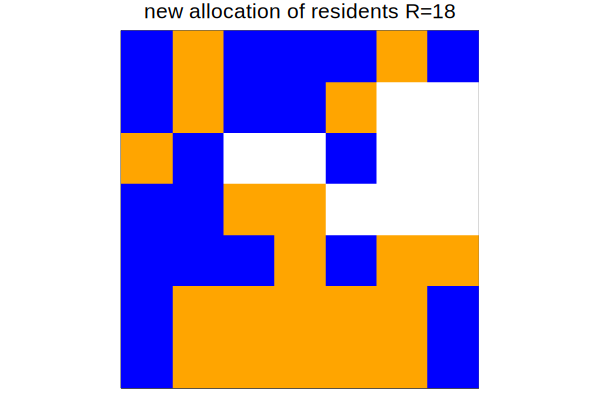

tt=4


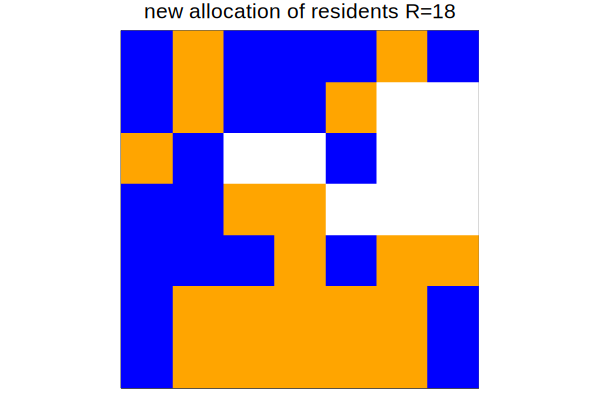

tt=5


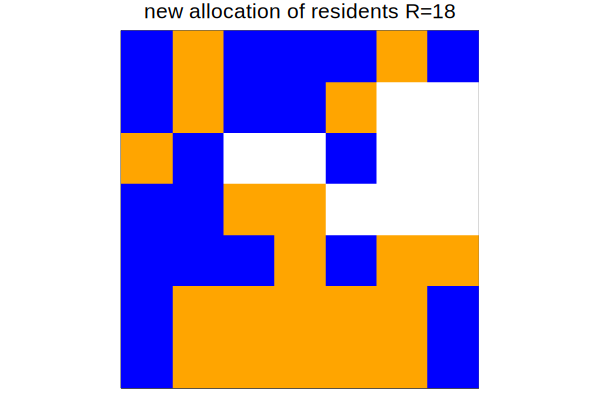

tt=6


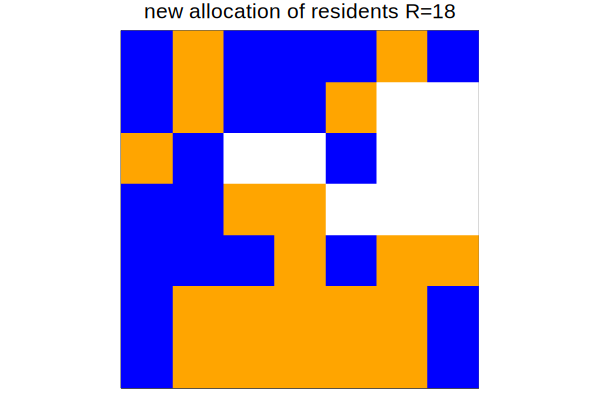

tt=7


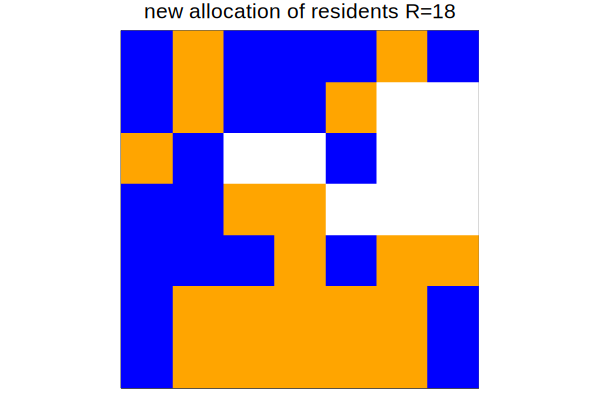

tt=8


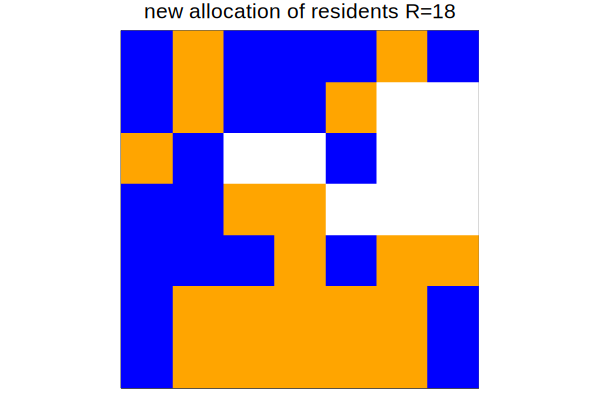

tt=9


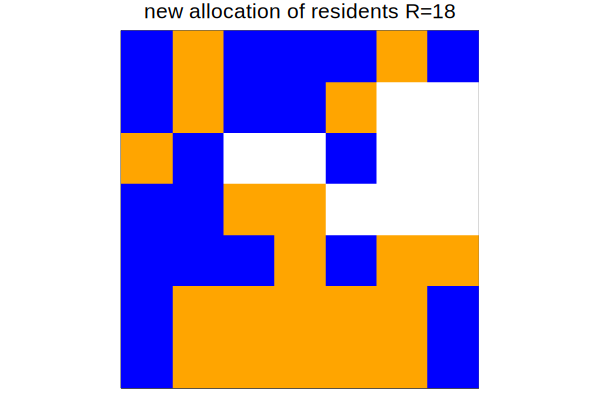

tt=10


In [134]:

TT = 10
gridDict = Dict()
gridDict[0] = start_grid

for tt in 1:TT

gridDict[tt] = move_cells_for_satisfaction(gridDict[tt-1])

end
#println(gridDict)


for tt in 0:TT
    println("tt=$tt")
    R = grid_satisfaction(gridDict[tt])
    hm = heatmap(gridDict[tt],title="new allocation of residents R=$(R)",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))
    display(hm)
end



In [32]:
using Documenter


ArgumentError: ArgumentError: Package Documenter not found in current path:
- Run `import Pkg; Pkg.add("Documenter")` to install the Documenter package.


$$\lambda + \beta$$
$$\frac{12}{4}$$

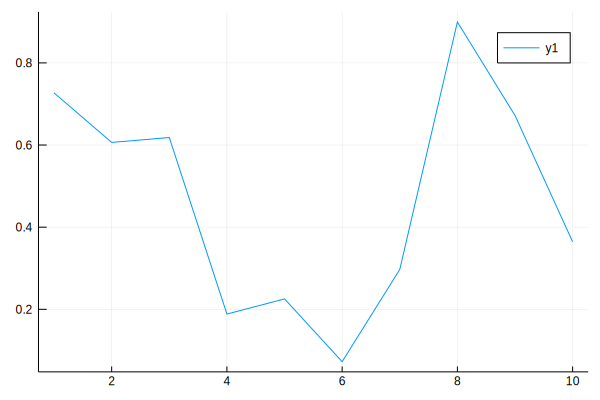

In [16]:
using Plots
plot(rand(10))

In [17]:
function f1(x)
    x = x^2
    return x+x
end

f1 (generic function with 1 method)

In [18]:
x=3
println(f1(x))

18


In [92]:
#old code


function grid_satisfactionOLD(start_grid) 
cell_satisfaction = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            cell_surrounding = []
            if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
                for ii in 0:2
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
                for ii in 0:1
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && col==1))#top left corner
                for ii in 1:2
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && col==GRID_SIZE))#top right corner
                for ii in 1:2
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==GRID_SIZE && col==1))#bottom left corner
                for ii in 0:1
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
                for ii in 1:2
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
                for ii in 0:2
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
            if( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
                for ii in 0:2
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
            if( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
                for ii in 0:1
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
        end
    end
#println(cell_satisfaction)
#println(size(cell_satisfaction))
#println(sum(cell_satisfaction))

    return sum(cell_satisfaction)
end

satisfiedOneGrid = grid_satisfactionOLD(start_grid)
println("random grid satisfactionOLD value=",satisfiedOneGrid)
R_MAX = grid_satisfactionOLD(set_grid)
println("set grid satisfactionOLD value=",R_MAX)